# &#x1F4D1; &nbsp;  House Prices: Advanced Regression Techniques

## 0. Code Library and Links

In [1]:
import numpy as np 
import pandas as pd 
import scipy

import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

In [3]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.linear_model import HuberRegressor, TheilSenRegressor, RANSACRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [4]:
import keras as ks
from keras.models import Sequential, load_model, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers.advanced_activations import PReLU
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [5]:
def regression(regressor, x_train, x_test, y_train):
    reg = regressor
    reg.fit(x_train, y_train)
    
    y_train_reg = reg.predict(x_train)
    y_test_reg = reg.predict(x_test)
    
    return y_train_reg, y_test_reg

In [6]:
def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    regressor_list.append(str(regressor))
    
    ev_train_c = explained_variance_score(y_train, y_train_reg)
    ev_train.append(ev_train_c)
    ev_test_c = explained_variance_score(y_test, y_test_reg)
    ev_test.append(ev_test_c)
    
    r2_train_c = r2_score(y_train, y_train_reg)
    r2_train.append(r2_train_c)
    r2_test_c = r2_score(y_test, y_test_reg)
    r2_test.append(r2_test_c)
    
    mse_train_c = mean_squared_error(y_train, y_train_reg)
    mse_train.append(mse_train_c)
    mse_test_c = mean_squared_error(y_test, y_test_reg)
    mse_test.append(mse_test_c)

    mae_train_c = mean_absolute_error(y_train, y_train_reg)
    mae_train.append(mae_train_c)
    mae_test_c = mean_absolute_error(y_test, y_test_reg)
    mae_test.append(mae_test_c)  
    
    mdae_train_c = median_absolute_error(y_train, y_train_reg)
    mdae_train.append(mdae_train_c)
    mdae_test_c = median_absolute_error(y_test, y_test_reg)
    mdae_test.append(mdae_test_c)
    
    print("______________________________________________________________________________")
    print(str(regressor))
    print("______________________________________________________________________________")
    print("EV score. Train: ", ev_train_c)
    print("EV score. Test: ", ev_test_c)
    print("---------")
    print("R2 score. Train: ", r2_train_c)
    print("R2 score. Test: ", r2_test_c)
    print("---------")
    print("MSE score. Train: ", mse_train_c)
    print("MSE score. Test: ", mse_test_c)
    print("---------")
    print("MAE score. Train: ", mae_train_c)
    print("MAE score. Test: ", mae_test_c)
    print("---------")
    print("MdAE score. Train: ", mdae_train_c)
    print("MdAE score. Test: ", mdae_test_c)

## 1. Input Preprocessing

In [7]:
# Load data
train = pd.read_csv('kaggle_house_train.csv')
test = pd.read_csv('kaggle_house_test.csv')

In [8]:
len(train)

1460

In [9]:
train.head().T[:15]

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


In [10]:
# Count NaN values
train_nulllist = train.isnull().sum()[train.isnull().sum()!=0].index.values.tolist()
train_null_list = [x for x in train_nulllist if x!='Electrical']

In [11]:
# Delete columns with a lot of NaN
for element in train_null_list:
    del train[element]
    del test[element]

In [12]:
train.isnull().sum()[train.isnull().sum()!=0]

Electrical    1
dtype: int64

In [13]:
test.isnull().sum()[test.isnull().sum()!=0]

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
SaleType        1
dtype: int64

In [14]:
# Fill in NaN values
most_common = pd.get_dummies(train['Electrical']).sum().sort_values(ascending=False).index[0]
train['Electrical'] = train['Electrical'].fillna(most_common)

test_cat_null_list = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 
                      'KitchenQual', 'Functional', 'SaleType']
test_num_null_list = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                      'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

for x in test_cat_null_list:
    most_common = pd.get_dummies(test[x]).sum().sort_values(ascending=False).index[0]
    test[x] = test[x].fillna(most_common)

for y in test_num_null_list:
    test[y] = test[y].fillna(test[y].median())

In [15]:
# Factorize categorical features
train_object_list = train.dtypes[train.dtypes=='object'].index.values.tolist()
print(train_object_list)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [16]:
for element in train_object_list:
    train_categories = pd.factorize(train[element])
    test_categories = pd.factorize(test[element])
    train[element] = train_categories[0]
    test[element] = test_categories[0]

In [17]:
float_list = test.dtypes[test.dtypes == 'float64'].index.values.tolist()
print(float_list)
for element in float_list:
    test[element] = test[element].astype(int)

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']


In [18]:
# Display correlation
pearson = train.corr(method='pearson')
corr_with_prices = pearson.iloc[-1][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]][:26]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Fireplaces      0.466929
Foundation     -0.429678
HeatingQC      -0.427649
BsmtFinSF1      0.386420
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotShape        0.267759
ExterQual      -0.265015
LotArea         0.263843
CentralAir     -0.251328
Electrical     -0.231417
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
PavedDrive     -0.208954
Name: SalePrice, dtype: float64

In [19]:
# Create feature list
features_list = corr_with_prices[abs(corr_with_prices).argsort()[::-1]][:26].index.values.tolist()

In [20]:
target_train = train['SalePrice'].as_matrix()
features_train = train[features_list].as_matrix()
features_test = test[features_list].as_matrix()

In [21]:
# Scale the data
scale_features = RobustScaler()
scale_target = RobustScaler()

scaled_features_train = scale_features.fit_transform(features_train)
scaled_features_test = scale_features.transform(features_test)
scaled_target_train = scale_target.fit_transform(target_train.reshape(-1,1))

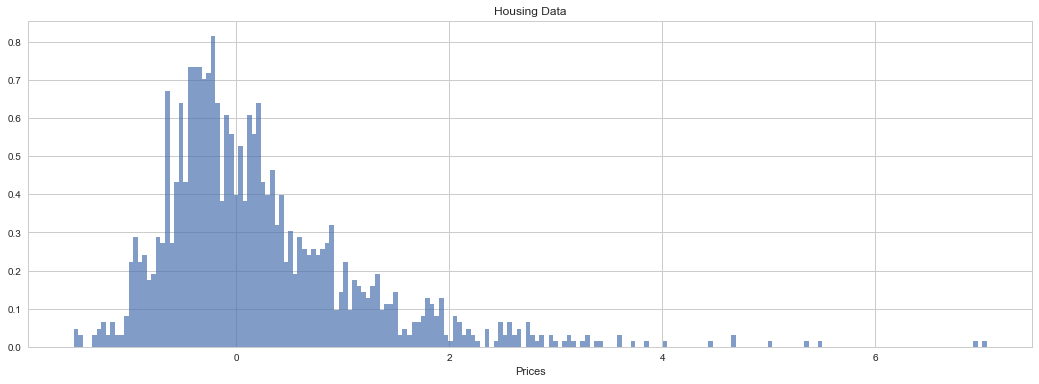

In [256]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(18, 6))

plt.hist(scaled_target_train, bins=200, normed=True, alpha=0.7)

plt.xlabel("Prices")
plt.title('Housing Data');

In [237]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features_train, scaled_target_train, 
                                                    test_size = 0.2, random_state = 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 26), (292, 26), (1168, 1), (292, 1))

In [238]:
X_train1 = X_train.reshape(1168, 26, 1)
X_test1 = X_test.reshape(292, 26, 1)

X_train2 = X_train.reshape(1168, 1, 26)
X_test2 = X_test.reshape(292, 1, 26)

## 2. Regressors

In [50]:
regressor_list = []
ev_train = []
ev_test = []
r2_train = []
r2_test = []
mse_train = []
mse_test = []
mae_train = []
mae_test = []
mdae_train = []
mdae_test = []

### Adaptive Boosting and Random Forest Regressors

In [51]:
y_train_abr, y_test_abr = regression(AdaBoostRegressor(), 
                                     X_train, X_test, y_train.reshape(-1))

y_train_rfr, y_test_rfr = regression(RandomForestRegressor(), 
                                     X_train, X_test, y_train.reshape(-1))

In [52]:
scores(AdaBoostRegressor(), y_train, y_test, y_train_abr, y_test_abr)
scores(RandomForestRegressor(), y_train, y_test, y_train_rfr, y_test_rfr)

______________________________________________________________________________
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)
______________________________________________________________________________
EV score. Train:  0.873081067556
EV score. Test:  0.896644036016
---------
R2 score. Train:  0.863883545021
R2 score. Test:  0.887549672394
---------
MSE score. Train:  0.11745429226
MSE score. Test:  0.113592999938
---------
MAE score. Train:  0.265348887921
MAE score. Test:  0.255569538103
---------
MdAE score. Train:  0.2049542501
MdAE score. Test:  0.190809974653
______________________________________________________________________________
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jo

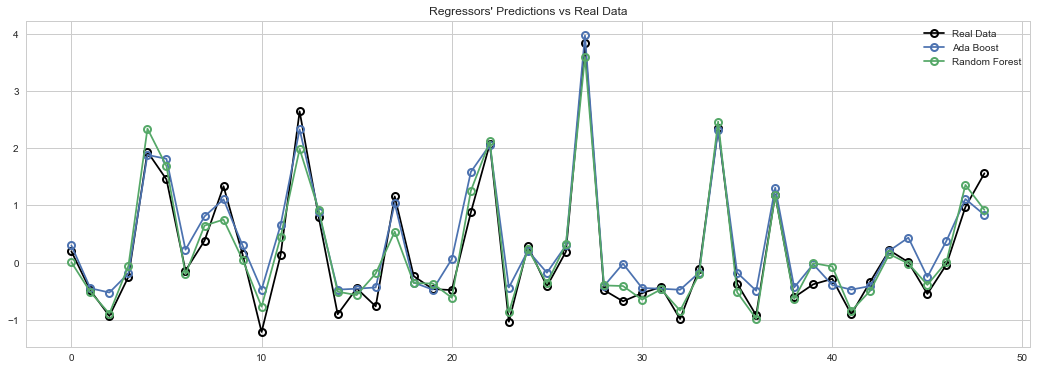

In [257]:
plt.figure(figsize = (18, 6))

plt.plot(y_test[1:50], '-o', color = 'black', label='Real Data',
         markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.plot(y_test_abr[1:50], '-o', label='Ada Boost',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(y_test_rfr[1:50], '-o', label='Random Forest',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Regressors' Predictions vs Real Data");

### Gradient Boosting and Bagging Regressors

In [54]:
y_train_gbr, y_test_gbr = regression(GradientBoostingRegressor(), 
                                     X_train, X_test, y_train.reshape(-1))

y_train_br, y_test_br = regression(BaggingRegressor(), 
                                   X_train, X_test, y_train.reshape(-1))

In [55]:
scores(GradientBoostingRegressor(), y_train, y_test, y_train_gbr, y_test_gbr)
scores(BaggingRegressor(), y_train, y_test, y_train_br, y_test_br)

______________________________________________________________________________
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
______________________________________________________________________________
EV score. Train:  0.955231977777
EV score. Test:  0.918253191613
---------
R2 score. Train:  0.955231977777
R2 score. Test:  0.917941700668
---------
MSE score. Train:  0.0386301301111
MSE score. Test:  0.0828921408175
---------
MAE score. Train:  0.142523624229
MAE score. Test:  0.194668856773
---------
MdAE score. Train:  0.106578333001
MdAE score. Test:  0.128482745083
______________________________________

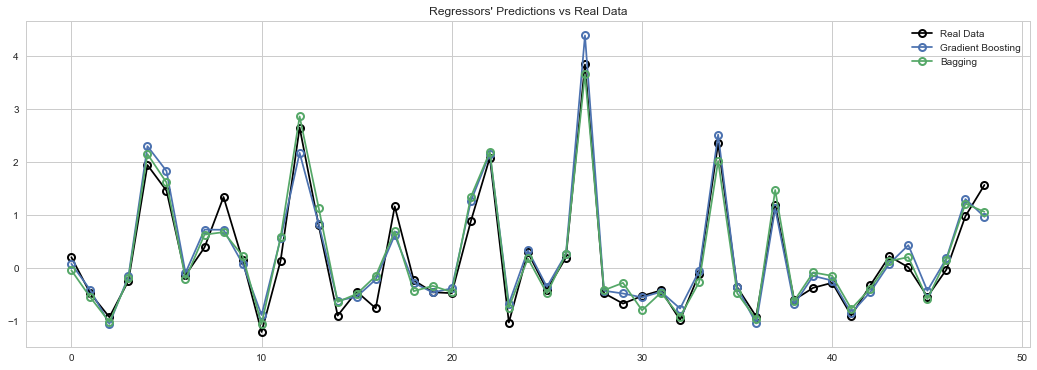

In [255]:
plt.figure(figsize = (18, 6))

plt.plot(y_test[1:50], '-o', color = 'black', label='Real Data',
         markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.plot(y_test_gbr[1:50], '-o', label='Gradient Boosting',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(y_test_br[1:50], '-o', label='Bagging',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Regressors' Predictions vs Real Data");

### Decision Tree and Extra Trees Regressors

In [57]:
y_train_dtr, y_test_dtr = regression(DecisionTreeRegressor(), 
                                     X_train, X_test, y_train.reshape(-1))

y_train_etr, y_test_etr = regression( ExtraTreesRegressor(), 
                                     X_train, X_test, y_train.reshape(-1))

In [58]:
scores(DecisionTreeRegressor(), y_train, y_test, y_train_dtr, y_test_dtr)
scores(ExtraTreesRegressor(), y_train, y_test, y_train_etr, y_test_etr)

______________________________________________________________________________
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
______________________________________________________________________________
EV score. Train:  0.999991206076
EV score. Test:  0.835784916951
---------
R2 score. Train:  0.999991206076
R2 score. Test:  0.835516507539
---------
MSE score. Train:  7.58823851431e-06
MSE score. Test:  0.166154903651
---------
MAE score. Train:  0.000163030409247
MAE score. Test:  0.289992948935
---------
MdAE score. Train:  0.0
MdAE score. Test:  0.208271347813
______________________________________________________________________________
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_lea

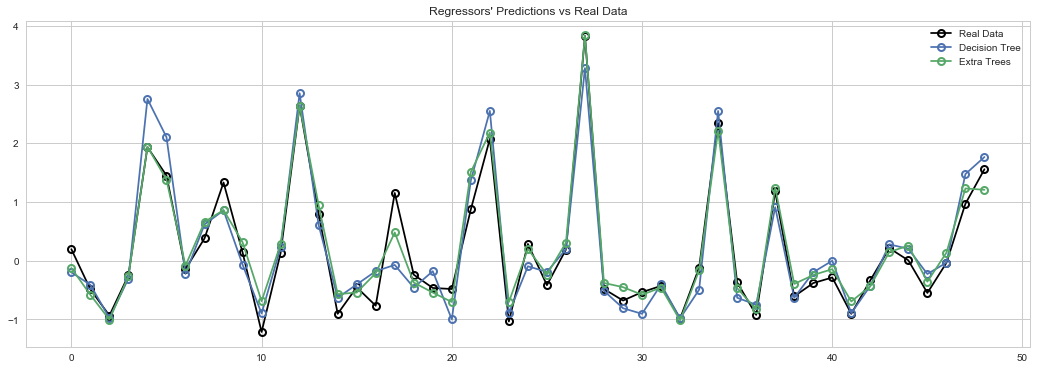

In [258]:
plt.figure(figsize = (18, 6))

plt.plot(y_test[1:50], '-o', color = 'black', label='Real Data',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.plot(y_test_dtr[1:50], '-o', label='Decision Tree',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(y_test_etr[1:50], '-o', label='Extra Trees',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Regressors' Predictions vs Real Data");

### K Neighbors and Radius Neighbors Regressors

In [60]:
y_train_knr, y_test_knr = regression(KNeighborsRegressor(n_neighbors=3), 
                                     X_train, X_test, y_train.reshape(-1))

y_train_rnr, y_test_rnr = regression(RadiusNeighborsRegressor(radius=5.575), 
                                     X_train, X_test, y_train.reshape(-1))

In [61]:
scores(KNeighborsRegressor(n_neighbors=3), y_train, y_test, y_train_knr, y_test_knr)
scores(RadiusNeighborsRegressor(radius=5.575), y_train, y_test, y_train_rnr, y_test_rnr)

______________________________________________________________________________
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')
______________________________________________________________________________
EV score. Train:  0.893837643961
EV score. Test:  0.870132135809
---------
R2 score. Train:  0.893542976255
R2 score. Test:  0.870004535888
---------
MSE score. Train:  0.0918612990766
MSE score. Test:  0.131316422648
---------
MAE score. Train:  0.186240946718
MAE score. Test:  0.228087598956
---------
MdAE score. Train:  0.120896558564
MdAE score. Test:  0.161190121988
______________________________________________________________________________
RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, p=2, radius=5.575, weights='uniform')
______________________________________________________________________________
E

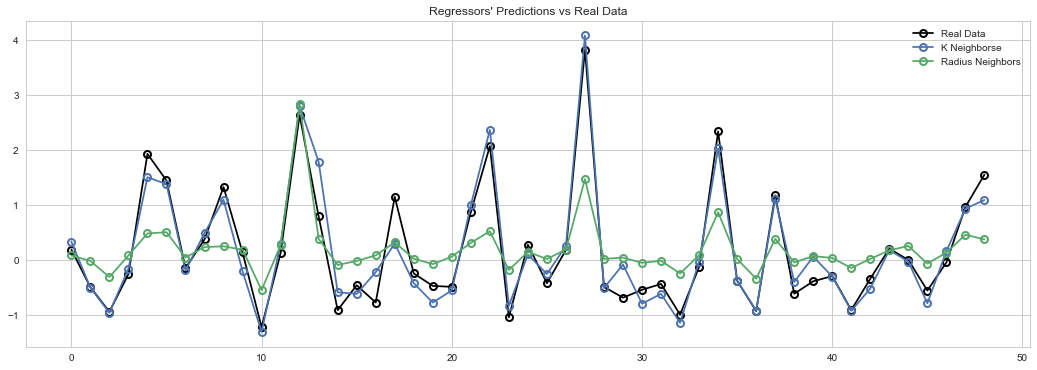

In [259]:
plt.figure(figsize = (18, 6))

plt.plot(y_test[1:50], '-o', color = 'black', label='Real Data',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.plot(y_test_knr[1:50], '-o', label='K Neighborse',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(y_test_rnr[1:50], '-o', label='Radius Neighbors',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Regressors' Predictions vs Real Data");

### Huber and SGD Regressors

In [63]:
y_train_hr, y_test_hr = regression(HuberRegressor(), 
                                     X_train, X_test, y_train.reshape(-1))

y_train_sgdr, y_test_sgdr = regression(SGDRegressor(n_iter=10), 
                                     X_train, X_test, y_train.reshape(-1))

In [64]:
scores(HuberRegressor(), y_train, y_test, y_train_hr, y_test_hr)
scores(SGDRegressor(n_iter=10), y_train, y_test, y_train_sgdr, y_test_sgdr)

______________________________________________________________________________
HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)
______________________________________________________________________________
EV score. Train:  0.769444337568
EV score. Test:  0.842548004822
---------
R2 score. Train:  0.768937280153
R2 score. Test:  0.84088183138
---------
MSE score. Train:  0.199383007965
MSE score. Test:  0.160735059675
---------
MAE score. Train:  0.245018967757
MAE score. Test:  0.246576461585
---------
MdAE score. Train:  0.155086735563
MdAE score. Test:  0.166150535256
______________________________________________________________________________
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=10, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
_____

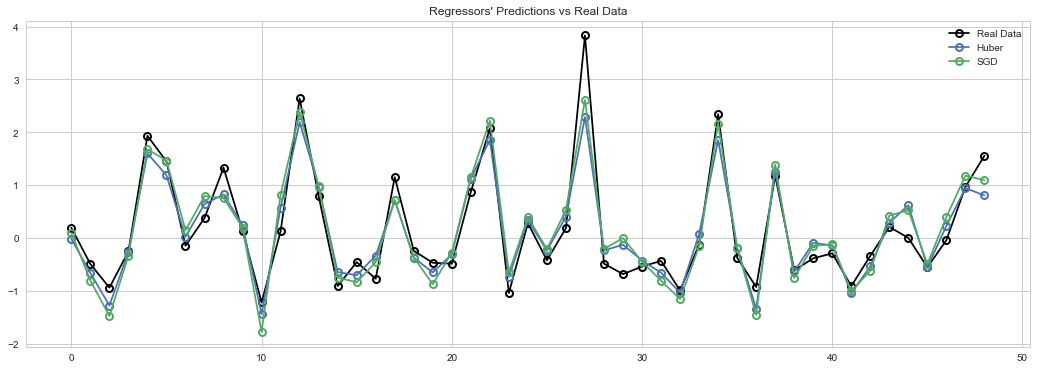

In [260]:
plt.figure(figsize = (18, 6))

plt.plot(y_test[1:50], '-o', color = 'black', label='Real Data',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.plot(y_test_hr[1:50], '-o', label='Huber',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(y_test_sgdr[1:50], '-o', label='SGD',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Regressors' Predictions vs Real Data");

## 3. Evaluation Metrics

In [66]:
df_results = pd.DataFrame({'regressor' : regressor_list,
                           'ev_train': ev_train,
                           'ev_test': ev_test,
                           'r2_train': r2_train,
                           'r2_test': r2_test,
                           'mse_train': mse_train,
                           'mse_test': mse_test,
                           'mae_train': mae_train,
                           'mae_test': mae_test,
                           'mdae_train': mdae_train,
                           'mdae_test': mdae_test})

In [67]:
df_results['regressor'][3]

'BaggingRegressor(base_estimator=None, bootstrap=True,\n         bootstrap_features=False, max_features=1.0, max_samples=1.0,\n         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,\n         verbose=0, warm_start=False)'

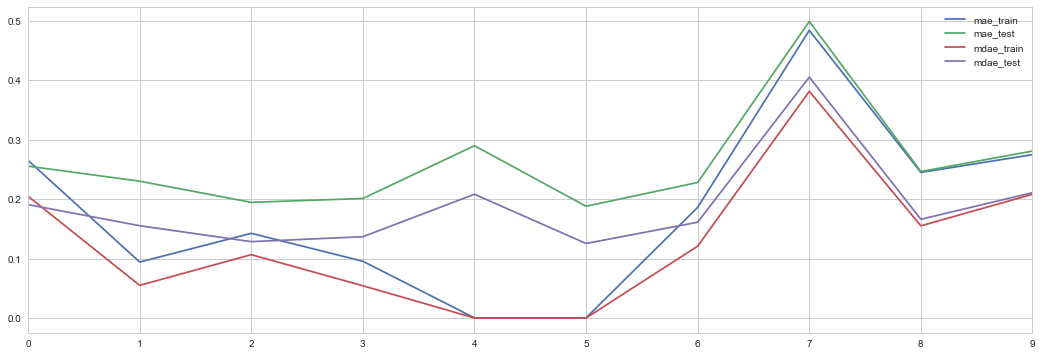

In [68]:
df_results[['mae_train', 'mae_test', 'mdae_train', 'mdae_test']].plot(figsize = (18, 6));

## 4. Tuning Algorithms

### Gradient Boosting Regressor

In [288]:
param_grid_gbr = {'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [3, 4, 5, 6], 
                  'n_estimators': range(52, 260, 26)}

gridsearch_gbr = GridSearchCV(GradientBoostingRegressor(), 
                              param_grid_gbr, n_jobs=10).fit(X_train, y_train.reshape(-1))

In [289]:
gridsearch_gbr.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 104}

In [290]:
regressor_gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=104)

y_train_gbr_best, y_test_gbr_best = regression(regressor_gbr, X_train, X_test, y_train.reshape(-1))

scores(regressor_gbr, y_train, y_test, y_train_gbr_best, y_test_gbr_best)

______________________________________________________________________________
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=104,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
______________________________________________________________________________
EV score. Train:  0.955794223781
EV score. Test:  0.918532829311
---------
R2 score. Train:  0.955794223781
R2 score. Test:  0.918177828014
---------
MSE score. Train:  0.0381449704994
MSE score. Test:  0.0826536140463
---------
MAE score. Train:  0.141439565515
MAE score. Test:  0.194959745331
---------
MdAE score. Train:  0.106074473865
MdAE score. Test:  0.128409295261


In [69]:
regressor_gbr = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, 
                                          n_estimators=182, 
                                          min_samples_leaf=1, min_samples_split=2)

y_train_gbr_best, y_test_gbr_best = regression(regressor_gbr, X_train, X_test, y_train.reshape(-1))

scores(regressor_gbr, y_train, y_test, y_train_gbr_best, y_test_gbr_best)

______________________________________________________________________________
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=182,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
______________________________________________________________________________
EV score. Train:  0.973699521555
EV score. Test:  0.927844214297
---------
R2 score. Train:  0.973699521555
R2 score. Test:  0.927623982107
---------
MSE score. Train:  0.0226945675474
MSE score. Test:  0.0731114721594
---------
MAE score. Train:  0.112262841182
MAE score. Test:  0.185485248958
---------
MdAE score. Train:  0.0843829608051
MdAE score. Test:  0.124807387964


### Bagging Regressor

In [292]:
param_grid_br = {'base_estimator': [DecisionTreeRegressor(), RandomForestRegressor(),
                                    GradientBoostingRegressor()],
                 'n_estimators': range(26, 260, 26)}

gridsearch_br = GridSearchCV(BaggingRegressor(), 
                             param_grid_br, n_jobs=5).fit(X_train, y_train.reshape(-1))

In [293]:
gridsearch_br.best_params_

{'base_estimator': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), 'n_estimators': 104}

In [294]:
regressor_br = BaggingRegressor(GradientBoostingRegressor(), n_estimators=104)

y_train_br_best, y_test_br_best = regression(regressor_br, X_train, X_test, y_train.reshape(-1))

scores(regressor_br, y_train, y_test, y_train_br_best, y_test_br_best)

______________________________________________________________________________
BaggingRegressor(base_estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=104, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
______________________________________________________________________________
EV score. Train:  0.943806893541
EV score. Test:  0.913571506936
---------
R2 score. Train:  0.943806701139
R2 score. Test:  0.913566678149
---------
MSE score. Train:  0.048488951233

In [295]:
regressor_br = BaggingRegressor(GradientBoostingRegressor(), n_estimators=208)

y_train_br_best, y_test_br_best = regression(regressor_br, X_train, X_test, y_train.reshape(-1))

scores(regressor_br, y_train, y_test, y_train_br_best, y_test_br_best)

______________________________________________________________________________
BaggingRegressor(base_estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=208, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
______________________________________________________________________________
EV score. Train:  0.942581005389
EV score. Test:  0.922861718661
---------
R2 score. Train:  0.94258059519
R2 score. Test:  0.922842696759
---------
MSE score. Train:  0.0495469526807

### Random Forest Regressor

In [296]:
param_grid_rfr = {'n_estimators': range(26, 261, 26)}

gridsearch_rfr = GridSearchCV(RandomForestRegressor(), 
                              param_grid_rfr, n_jobs=10).fit(X_train, y_train.reshape(-1))

In [297]:
gridsearch_rfr.best_params_

{'n_estimators': 260}

In [298]:
regressor_rfr = RandomForestRegressor(n_estimators=260)

y_train_rfr_best, y_test_rfr_best = regression(regressor_rfr, X_train, X_test, y_train.reshape(-1))

scores(regressor_rfr, y_train, y_test, y_train_rfr_best, y_test_rfr_best)

______________________________________________________________________________
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=260, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
______________________________________________________________________________
EV score. Train:  0.977296277442
EV score. Test:  0.913634802866
---------
R2 score. Train:  0.977296015721
R2 score. Test:  0.913629592091
---------
MSE score. Train:  0.0195911684987
MSE score. Test:  0.0872480672058
---------
MAE score. Train:  0.0810246852493
MAE score. Test:  0.198560147274
---------
MdAE score. Train:  0.0514397958483
MdAE score. Test:  0.137730620466


### Extra Trees Regressor

In [299]:
param_grid_etr = {'n_estimators': range(26, 261, 26)}

gridsearch_etr = GridSearchCV(ExtraTreesRegressor(), 
                              param_grid_etr, n_jobs=10).fit(X_train, y_train.reshape(-1))

In [300]:
gridsearch_etr.best_params_

{'n_estimators': 156}

In [301]:
regressor_etr = ExtraTreesRegressor(n_estimators=156)

y_train_etr_best, y_test_etr_best = regression(regressor_etr, X_train, X_test, y_train.reshape(-1))

scores(regressor_etr, y_train, y_test, y_train_etr_best, y_test_etr_best)

______________________________________________________________________________
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=156, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
______________________________________________________________________________
EV score. Train:  0.999991206704
EV score. Test:  0.918055771704
---------
R2 score. Train:  0.999991206704
R2 score. Test:  0.918004782662
---------
MSE score. Train:  7.58769635761e-06
MSE score. Test:  0.0828284178114
---------
MAE score. Train:  0.000161596643017
MAE score. Test:  0.183406742521
---------
MdAE score. Train:  6.66133814775e-16
MdAE score. Test:  0.113183080432


## 5. Regressor Predictions

In [26]:
reg = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=182, 
                                min_samples_leaf=1, min_samples_split=2)
reg.fit(scaled_features_train, scaled_target_train.reshape(-1))

scaled_target_train_predict = reg.predict(scaled_features_train)
scaled_target_test_predict = reg.predict(scaled_features_test)

In [27]:
print("_______________________________________")
print("Gradient Boosting  Regressor")
print("_______________________________________")
print("EV score. Train: ", explained_variance_score(scaled_target_train.reshape(-1), 
                                                    scaled_target_train_predict))
print("---------")
print("R2 score. Train: ", r2_score(scaled_target_train.reshape(-1), 
                                    scaled_target_train_predict))
print("---------")
print("MSE score. Train: ", mean_squared_error(scaled_target_train.reshape(-1), 
                                               scaled_target_train_predict))
print("---------")
print("MAE score. Train: ", mean_absolute_error(scaled_target_train.reshape(-1), 
                                                scaled_target_train_predict))
print("---------")
print("MdAE score. Train: ", median_absolute_error(scaled_target_train.reshape(-1), 
                                                   scaled_target_train_predict))

_______________________________________
Gradient Boosting  Regressor
_______________________________________
EV score. Train:  0.971765829663
---------
R2 score. Train:  0.971765829663
---------
MSE score. Train:  0.0252212299132
---------
MAE score. Train:  0.118072329713
---------
MdAE score. Train:  0.0883645847931


In [28]:
target_test_predict = scale_target.inverse_transform(scaled_target_test_predict.reshape(1,-1))
target_predict = ["{0:.2f}".format(x) for x in target_test_predict.reshape(-1)]

submission = pd.DataFrame({"Id": test['Id'], "SalePrice": target_predict})
print(submission[0:20])

submission.to_csv('kaggle_housing_gbr.csv', index=False)

      Id  SalePrice
0   1461  128989.49
1   1462  155758.20
2   1463  185106.60
3   1464  187800.16
4   1465  187495.69
5   1466  177394.17
6   1467  174630.95
7   1468  169369.75
8   1469  187115.29
9   1470  127268.20
10  1471  198836.25
11  1472   99271.52
12  1473   97274.86
13  1474  157593.66
14  1475  135383.36
15  1476  361940.87
16  1477  252019.84
17  1478  304452.20
18  1479  260164.66
19  1480  466742.26


In [29]:
reg1 = BaggingRegressor(GradientBoostingRegressor(), n_estimators=104)

reg1.fit(scaled_features_train, scaled_target_train.reshape(-1))

scaled_target_train_predict1 = reg1.predict(scaled_features_train)
scaled_target_test_predict1 = reg1.predict(scaled_features_test)

In [30]:
print("_______________________________________")
print("Bagging  Regressor")
print("_______________________________________")
print("EV score. Train: ", explained_variance_score(scaled_target_train.reshape(-1), 
                                                    scaled_target_train_predict1))
print("---------")
print("R2 score. Train: ", r2_score(scaled_target_train.reshape(-1), 
                                    scaled_target_train_predict1))
print("---------")
print("MSE score. Train: ", mean_squared_error(scaled_target_train.reshape(-1), 
                                               scaled_target_train_predict1))
print("---------")
print("MAE score. Train: ", mean_absolute_error(scaled_target_train.reshape(-1), 
                                                scaled_target_train_predict1))
print("---------")
print("MdAE score. Train: ", median_absolute_error(scaled_target_train.reshape(-1), 
                                                   scaled_target_train_predict1))

_______________________________________
Bagging  Regressor
_______________________________________
EV score. Train:  0.945500444696
---------
R2 score. Train:  0.945498592092
---------
MSE score. Train:  0.0486854234795
---------
MAE score. Train:  0.152123772926
---------
MdAE score. Train:  0.105667554263


In [31]:
target_test_predict1 = scale_target.inverse_transform(scaled_target_test_predict1.reshape(1,-1))
target_predict1 = ["{0:.2f}".format(x) for x in target_test_predict1.reshape(-1)]

submission1 = pd.DataFrame({"Id": test['Id'], "SalePrice": target_predict1})
print(submission1[0:20])

submission1.to_csv('kaggle_housing_br.csv', index=False)

      Id  SalePrice
0   1461  127846.87
1   1462  161038.15
2   1463  183486.24
3   1464  184079.24
4   1465  199830.17
5   1466  179484.18
6   1467  172779.12
7   1468  166824.06
8   1469  184244.76
9   1470  126439.53
10  1471  204028.98
11  1472   99799.73
12  1473   97779.16
13  1474  154075.99
14  1475  131410.47
15  1476  394023.52
16  1477  265098.33
17  1478  293927.67
18  1479  274556.82
19  1480  475955.44


In [32]:
reg2 = RandomForestRegressor(n_estimators=260)

reg2.fit(scaled_features_train, scaled_target_train.reshape(-1))

scaled_target_train_predict2 = reg2.predict(scaled_features_train)
scaled_target_test_predict2 = reg2.predict(scaled_features_test)

In [33]:
print("_______________________________________")
print("Random Forest  Regressor")
print("_______________________________________")
print("EV score. Train: ", explained_variance_score(scaled_target_train.reshape(-1), 
                                                    scaled_target_train_predict2))
print("---------")
print("R2 score. Train: ", r2_score(scaled_target_train.reshape(-1), 
                                    scaled_target_train_predict2))
print("---------")
print("MSE score. Train: ", mean_squared_error(scaled_target_train.reshape(-1), 
                                               scaled_target_train_predict2))
print("---------")
print("MAE score. Train: ", mean_absolute_error(scaled_target_train.reshape(-1), 
                                                scaled_target_train_predict2))
print("---------")
print("MdAE score. Train: ", median_absolute_error(scaled_target_train.reshape(-1), 
                                                   scaled_target_train_predict2))

_______________________________________
Random Forest  Regressor
_______________________________________
EV score. Train:  0.980780408031
---------
R2 score. Train:  0.980779063321
---------
MSE score. Train:  0.0171698214376
---------
MAE score. Train:  0.0790070458747
---------
MdAE score. Train:  0.0508023939762


In [34]:
target_test_predict2 = scale_target.inverse_transform(scaled_target_test_predict2.reshape(1,-1))
target_predict2 = ["{0:.2f}".format(x) for x in target_test_predict2.reshape(-1)]

submission2 = pd.DataFrame({"Id": test['Id'], "SalePrice": target_predict2})
print(submission2[0:20])

submission2.to_csv('kaggle_housing_rfr.csv', index=False)

      Id  SalePrice
0   1461  125617.01
1   1462  156516.05
2   1463  186335.08
3   1464  183828.62
4   1465  198492.09
5   1466  183103.83
6   1467  173090.99
7   1468  175264.58
8   1469  180123.42
9   1470  119641.23
10  1471  195811.54
11  1472   99775.70
12  1473   97054.55
13  1474  155639.63
14  1475  133852.14
15  1476  379483.68
16  1477  257443.16
17  1478  295231.91
18  1479  226031.06
19  1480  456264.77


In [35]:
reg3 = ExtraTreesRegressor(n_estimators=156)

reg3.fit(scaled_features_train, scaled_target_train.reshape(-1))

scaled_target_train_predict3 = reg3.predict(scaled_features_train)
scaled_target_test_predict3 = reg3.predict(scaled_features_test)

In [36]:
print("_______________________________________")
print("Extra Trees Regressor")
print("_______________________________________")
print("EV score. Train: ", explained_variance_score(scaled_target_train.reshape(-1), 
                                                    scaled_target_train_predict3))
print("---------")
print("R2 score. Train: ", r2_score(scaled_target_train.reshape(-1), 
                                    scaled_target_train_predict3))
print("---------")
print("MSE score. Train: ", mean_squared_error(scaled_target_train.reshape(-1), 
                                               scaled_target_train_predict3))
print("---------")
print("MAE score. Train: ", mean_absolute_error(scaled_target_train.reshape(-1), 
                                                scaled_target_train_predict3))
print("---------")
print("MdAE score. Train: ", median_absolute_error(scaled_target_train.reshape(-1), 
                                                   scaled_target_train_predict3))

_______________________________________
Extra Trees Regressor
_______________________________________
EV score. Train:  0.999993204715
---------
R2 score. Train:  0.999993204715
---------
MSE score. Train:  6.07014258743e-06
---------
MAE score. Train:  0.00012925130967
---------
MdAE score. Train:  6.93889390391e-16


In [37]:
target_test_predict3 = scale_target.inverse_transform(scaled_target_test_predict3.reshape(1,-1))
target_predict3 = ["{0:.2f}".format(x) for x in target_test_predict3.reshape(-1)]

submission3 = pd.DataFrame({"Id": test['Id'], "SalePrice": target_predict3})
print(submission3[0:20])

submission3.to_csv('kaggle_housing_etr.csv', index=False)

      Id  SalePrice
0   1461  128278.74
1   1462  157524.78
2   1463  185768.97
3   1464  184934.84
4   1465  185500.66
5   1466  179547.48
6   1467  180703.72
7   1468  169711.96
8   1469  185628.24
9   1470  124180.56
10  1471  184979.58
11  1472  108866.04
12  1473  109662.40
13  1474  168532.72
14  1475  126778.88
15  1476  391477.35
16  1477  251184.31
17  1478  300032.24
18  1479  244171.78
19  1480  466405.51


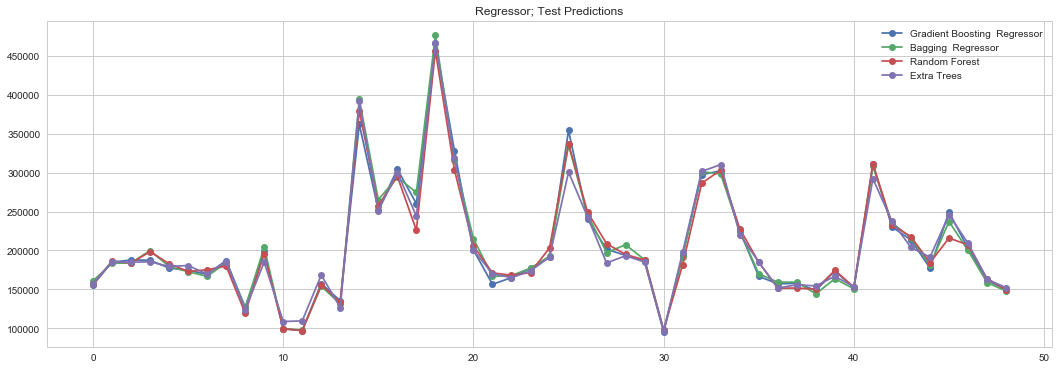

In [265]:
plt.figure(figsize = (18, 6))

plt.plot(target_predict[1:50], '-o', label='Gradient Boosting  Regressor')
plt.plot(target_predict1[1:50], '-o', label='Bagging  Regressor')
plt.plot(target_predict2[1:50], '-o', label='Random Forest')
plt.plot(target_predict3[1:50], '-o', label='Extra Trees')

plt.legend()
plt.title('Regressor; Test Predictions');

##  6. Features' Importance

In [39]:
df_importance = pd.DataFrame(columns=range(26))

df_importance.loc[0] = AdaBoostRegressor().fit(X_train, y_train.reshape(-1)).feature_importances_
df_importance.loc[1] = RandomForestRegressor().fit(X_train, y_train.reshape(-1)).feature_importances_
df_importance.loc[2] = GradientBoostingRegressor().fit(X_train, y_train.reshape(-1)).feature_importances_
df_importance.loc[3]= DecisionTreeRegressor().fit(X_train, y_train.reshape(-1)).feature_importances_
df_importance.loc[4] = ExtraTreesRegressor().fit(X_train, y_train.reshape(-1)).feature_importances_

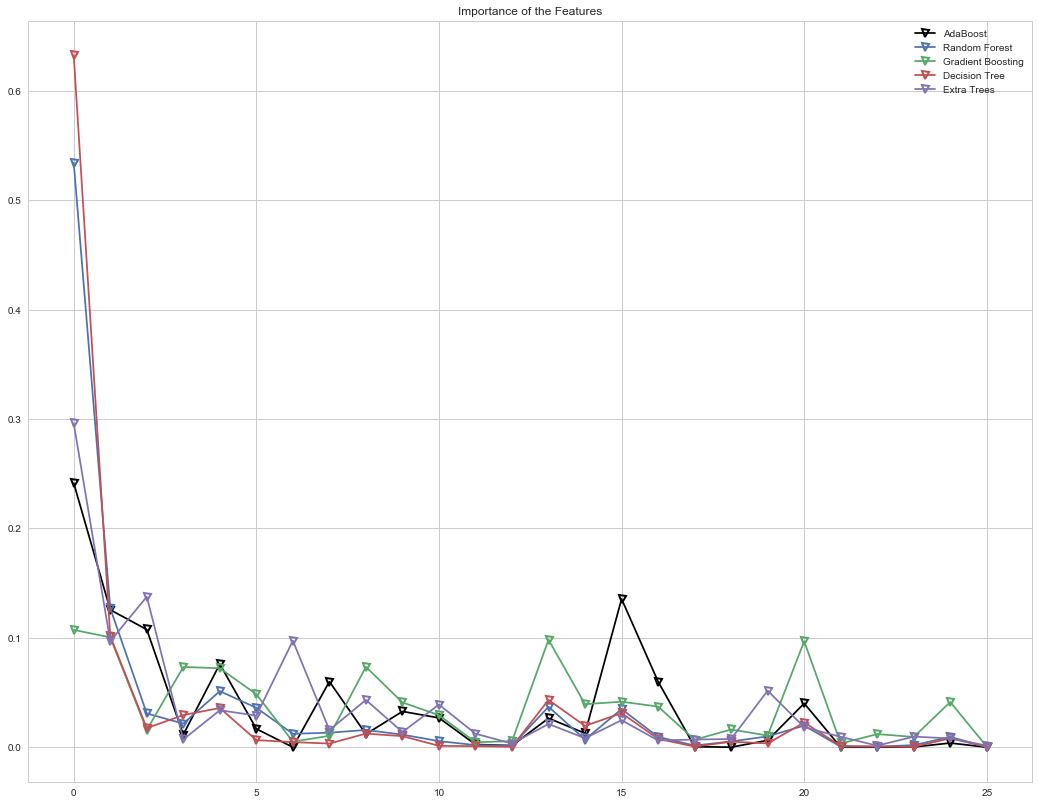

In [40]:
plt.figure(figsize = (18, 14))

plt.plot(df_importance.loc[0], '-v', color = 'black', label='AdaBoost',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance.loc[1], '-v', label='Random Forest',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance.loc[2], '-v', label='Gradient Boosting',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance.loc[3], '-v', label='Decision Tree',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance.loc[4], '-v', label='Extra Trees',
        markersize=7, markerfacecolor="None", markeredgewidth=2)


plt.legend()
plt.title("Importance of the Features");

In [41]:
column_pairs = dict(zip(list(range(26)), list(features_list)))
index_pairs = dict(zip(list(range(5)), 
                       list(['AdaBoost', 'Random Forest', 'Gradient Boosting', 'Decision Tree', 'Extra Trees'])))
df_importance2 = df_importance.rename(index=index_pairs, columns=column_pairs)
df_importance2.T

,AdaBoost,Random Forest,Gradient Boosting,Decision Tree,Extra Trees
OverallQual,0.241449,0.534421,0.107259,0.632513,0.296096
GrLivArea,0.125586,0.127086,0.100459,0.101524,0.096881
GarageCars,0.107615,0.030832,0.015707,0.017444,0.137576
GarageArea,0.011527,0.021582,0.073353,0.029391,0.007101
TotalBsmtSF,0.076000,0.051245,0.072192,0.035840,0.033797
1stFlrSF,0.016793,0.036012,0.048415,0.006497,0.028864
FullBath,0.000000,0.012261,0.005100,0.004647,0.097409
TotRmsAbvGrd,0.060016,0.013251,0.010390,0.003340,0.015700
YearBuilt,0.011977,0.015741,0.073432,0.012420,0.043195
YearRemodAdd,0.032697,0.011490,0.040922,0.010111,0.013866


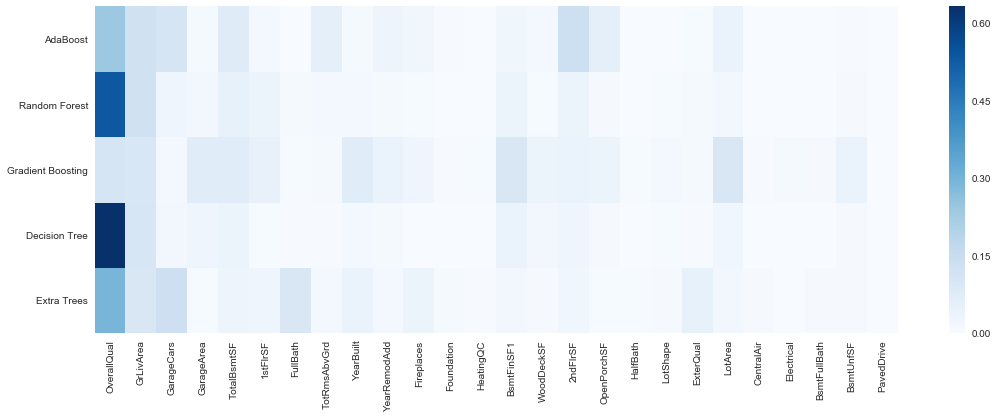

In [42]:
plt.figure(figsize = (18, 6))
sns.heatmap(df_importance2, cmap='Blues');

## 7. Regressor Ensembles

## 8. Regressor Ensembles Predictions

## 9. Neural Network Regressors

In [108]:
def loss_plot(fit_history):
    plt.figure(figsize=(18, 3))

    plt.plot(fit_history.history['loss'][3:], label = 'train')
    plt.plot(fit_history.history['val_loss'][3:], label = 'test')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history):
    plt.figure(figsize=(18, 3))

    plt.plot(fit_history.history['mean_absolute_error'][3:], label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'][3:], label = 'test')

    plt.legend()
    plt.title('Mean Absolute Error');
    
def compare_gbr_plot(y_test_r, regressor_name):
    plt.figure(figsize=(18, 6))

    plt.plot(range(50), y_test[:50], '-o', color = 'black', label = 'Real Data')

    plt.plot(range(50), y_test_r.reshape(-1)[:50], '-o', label = 'Neural Network Regressor')
    plt.plot(range(50), y_test_gbr_best[:50], '-o', label = 'Gradient Boosting Regressor')

    plt.legend()
    plt.title(regressor_name);    

In [188]:
# MLP: Regression
def mlp_reg_model():
    model = Sequential()
    
    model.add(Dense(1664, activation='relu', input_dim=26)) 
    model.add(Dense(416, activation='relu'))
    
    model.add(Dense(104, activation='relu')) 
    model.add(Dense(26, activation='relu'))
    
    model.add(Dense(1))

    model.compile(optimizer='nadam', loss='mse', metrics=['mae']) 
    
    return model

In [189]:
mlp_reg_model = mlp_reg_model()
mlp_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_reg.housing.hdf5', verbose=2, save_best_only=True)
mlp_reg_history = mlp_reg_model.fit(X_train, y_train,  validation_data=(X_test, y_test), 
                                    epochs=30, batch_size=8, verbose=2, callbacks=[mlp_checkpointer])

Train on 1168 samples, validate on 292 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 0.66840, saving model to weights.best.mlp_reg.housing.hdf5
6s - loss: 0.4166 - mean_absolute_error: 0.3472 - val_loss: 0.6684 - val_mean_absolute_error: 0.5078
Epoch 2/30
Epoch 00001: val_loss improved from 0.66840 to 0.27199, saving model to weights.best.mlp_reg.housing.hdf5
3s - loss: 0.2989 - mean_absolute_error: 0.2871 - val_loss: 0.2720 - val_mean_absolute_error: 0.3678
Epoch 3/30
Epoch 00002: val_loss improved from 0.27199 to 0.20152, saving model to weights.best.mlp_reg.housing.hdf5
3s - loss: 0.2640 - mean_absolute_error: 0.2704 - val_loss: 0.2015 - val_mean_absolute_error: 0.2372
Epoch 4/30
Epoch 00003: val_loss improved from 0.20152 to 0.10844, saving model to weights.best.mlp_reg.housing.hdf5
3s - loss: 0.2064 - mean_absolute_error: 0.2528 - val_loss: 0.1084 - val_mean_absolute_error: 0.2138
Epoch 5/30
Epoch 00004: val_loss did not improve
3s - loss: 0.2663 - mean_absolute_er

In [190]:
mlp_reg_model.load_weights('weights.best.mlp_reg.housing.hdf5')
y_train_mlp_predictions = mlp_reg_model.predict(X_train)
y_test_mlp_predictions = mlp_reg_model.predict(X_test)

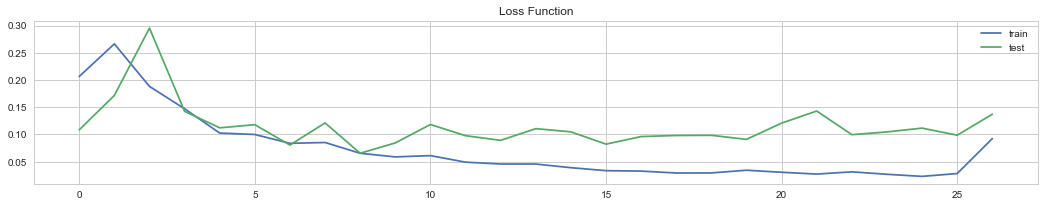

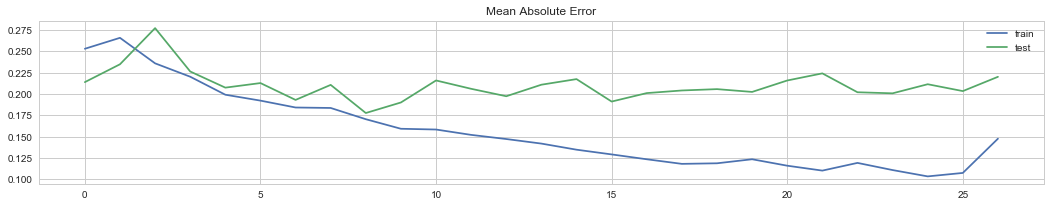

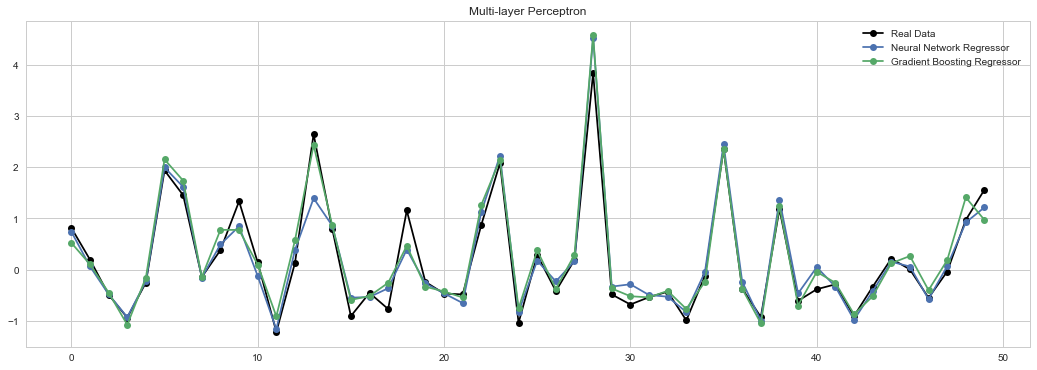

In [263]:
loss_plot(mlp_reg_history)
mae_plot(mlp_reg_history)
compare_gbr_plot(y_test_mlp_predictions, 'Multi-layer Perceptron')

In [192]:
mlp_reg_test_score = mlp_reg_model.evaluate(X_test, y_test, batch_size=292)
mlp_reg_test_score
# Gradient Boosting Regressor. MSE Score, Test: 0.0731114721594. MAE score, Test: 0.185485248958.

292/292 [==============================] - 0s


[0.06550869345664978, 0.17761765420436859]

In [212]:
# CNN: Regression
def cnn_reg_model():
    model = Sequential()
        
    model.add(Conv1D(42, 3, padding='valid', activation='relu', input_shape=(26,1)))
    model.add(Conv1D(42, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(84, 3, padding='valid', activation='relu'))
    model.add(Conv1D(84, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
     
    model.add(Flatten())

    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model    

In [213]:
cnn_reg_model = cnn_reg_model()
cnn_checkpointer = ModelCheckpoint(filepath='weights.best.cnn_reg.housing.hdf5', verbose=0, save_best_only=True)
cnn_reg_history = cnn_reg_model.fit(X_train1, y_train,validation_data=(X_test1, y_test), 
                                    epochs=50, batch_size=16, verbose=0, callbacks=[cnn_checkpointer])

In [214]:
cnn_reg_model.load_weights('weights.best.cnn_reg.housing.hdf5')
y_train_cnn_predictions = cnn_reg_model.predict(X_train1)
y_test_cnn_predictions = cnn_reg_model.predict(X_test1)

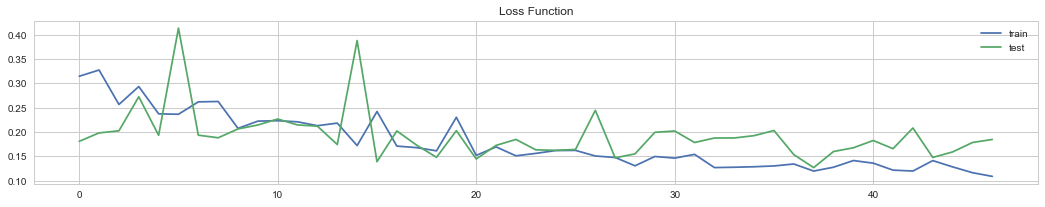

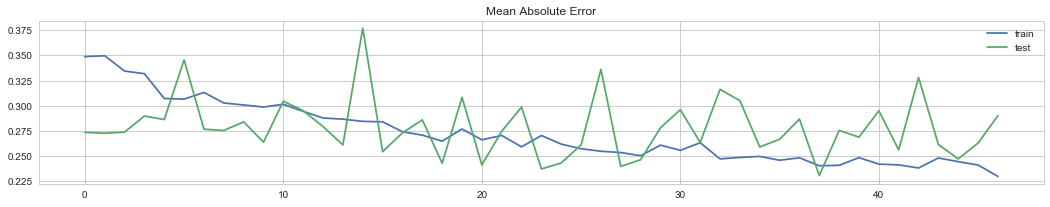

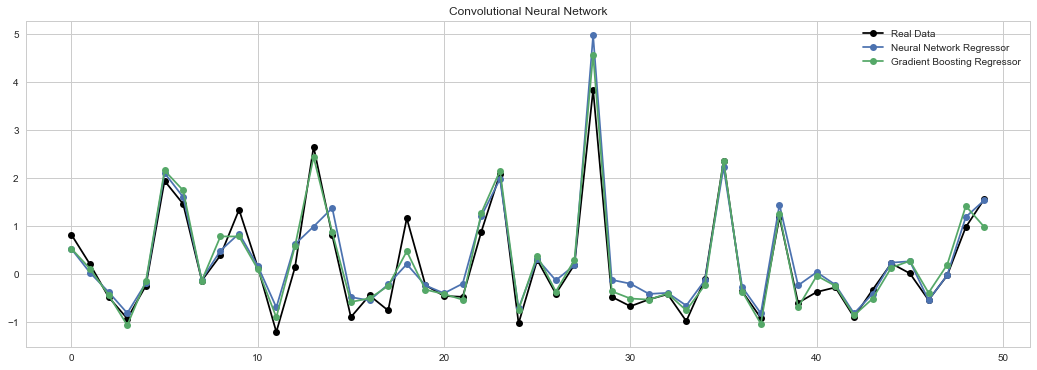

In [215]:
loss_plot(cnn_reg_history)
mae_plot(cnn_reg_history)
compare_gbr_plot(y_test_cnn_predictions, 'Convolutional Neural Network')

In [217]:
cnn_reg_test_score = cnn_reg_model.evaluate(X_test1, y_test, batch_size=292)
cnn_reg_test_score
# Gradient Boosting Regressor. MSE Score, Test: 0.0731114721594. MAE score, Test: 0.185485248958.

292/292 [==============================] - 0s


[0.12696255743503571, 0.23064862191677094]

In [239]:
# RNN: Regression
def rnn_reg_model():
    model = Sequential()
    model.add(LSTM(104, return_sequences=True, input_shape=(1, 26)))
    model.add(LSTM(104, return_sequences=True))
    
    model.add(LSTM(208, return_sequences=False))   
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    return model

In [240]:
rnn_reg_model = rnn_reg_model()
rnn_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_reg.housing.hdf5', verbose=2, save_best_only=True)
rnn_reg_history = rnn_reg_model.fit(X_train2, y_train, validation_data=(X_test2, y_test), 
                                    epochs=10, batch_size=64, verbose=2, callbacks=[rnn_checkpointer])

Train on 1168 samples, validate on 292 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.22132, saving model to weights.best.rnn_reg.housing.hdf5
7s - loss: 0.4781 - mean_absolute_error: 0.4435 - val_loss: 0.2213 - val_mean_absolute_error: 0.3293
Epoch 2/10
Epoch 00001: val_loss improved from 0.22132 to 0.12027, saving model to weights.best.rnn_reg.housing.hdf5
0s - loss: 0.1752 - mean_absolute_error: 0.2471 - val_loss: 0.1203 - val_mean_absolute_error: 0.2364
Epoch 3/10
Epoch 00002: val_loss did not improve
0s - loss: 0.1600 - mean_absolute_error: 0.2327 - val_loss: 0.1211 - val_mean_absolute_error: 0.2328
Epoch 4/10
Epoch 00003: val_loss did not improve
0s - loss: 0.1428 - mean_absolute_error: 0.2293 - val_loss: 0.1259 - val_mean_absolute_error: 0.2166
Epoch 5/10
Epoch 00004: val_loss improved from 0.12027 to 0.11583, saving model to weights.best.rnn_reg.housing.hdf5
0s - loss: 0.1408 - mean_absolute_error: 0.2232 - val_loss: 0.1158 - val_mean_absolute_error: 0.2273
Epo

In [241]:
rnn_reg_model.load_weights('weights.best.rnn_reg.housing.hdf5')
y_train_rnn_predictions = rnn_reg_model.predict(X_train2)
y_test_rnn_predictions = rnn_reg_model.predict(X_test2)

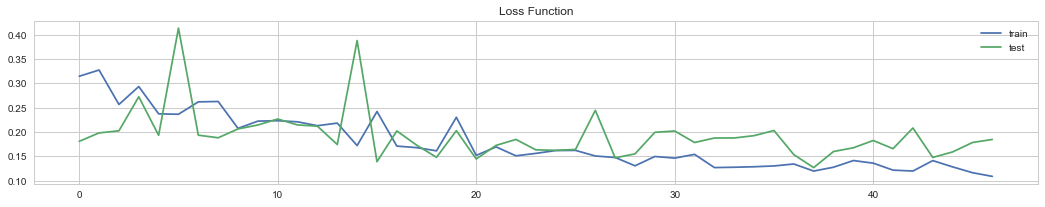

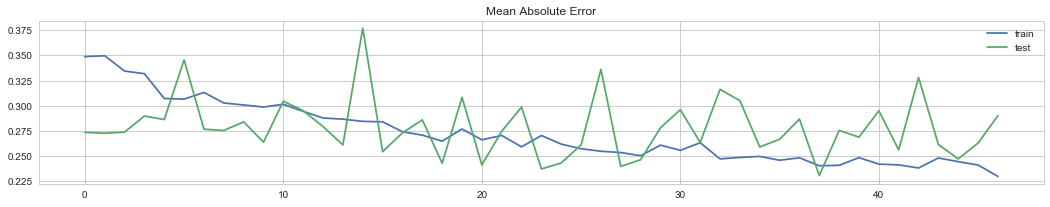

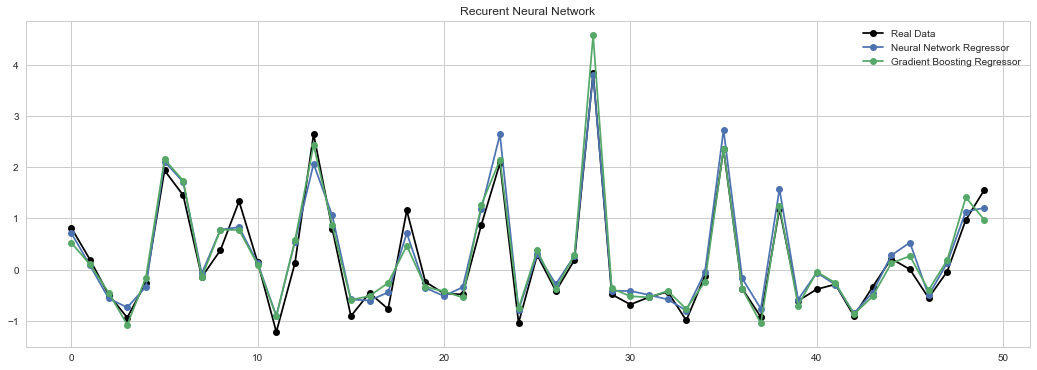

In [242]:
loss_plot(cnn_reg_history)
mae_plot(cnn_reg_history)
compare_gbr_plot(y_test_rnn_predictions, 'Recurent Neural Network')

In [243]:
rnn_reg_test_score = rnn_reg_model.evaluate(X_test2, y_test, batch_size=292)
rnn_reg_test_score
# Gradient Boosting Regressor. MSE Score, Test: 0.0731114721594. MAE score, Test: 0.185485248958.

292/292 [==============================] - 0s


[0.10721337795257568, 0.2074076235294342]

## 10. Neural Network Predictions

In [252]:
scaled_target_train_mlp = mlp_reg_model.predict(scaled_features_train)
scaled_target_test_mlp = mlp_reg_model.predict(scaled_features_test)

In [253]:
target_test_mlp = scale_target.inverse_transform(scaled_target_test_mlp.reshape(1,-1))
target_mlp = ["{0:.2f}".format(x) for x in target_test_mlp.reshape(-1)]

submission_mlp = pd.DataFrame({"Id": test['Id'], "SalePrice": target_mlp})
print(submission_mlp[0:20])

submission_mlp.to_csv('kaggle_housing_mlp.csv', index=False)

      Id  SalePrice
0   1461  137785.17
1   1462  162584.17
2   1463  178243.20
3   1464  178911.02
4   1465  172670.33
5   1466  175258.56
6   1467  170948.42
7   1468  164078.47
8   1469  185900.34
9   1470  134377.23
10  1471  198049.78
11  1472  107524.24
12  1473  103975.80
13  1474  148764.58
14  1475  109897.38
15  1476  390621.56
16  1477  240096.03
17  1478  288526.75
18  1479  294094.38
19  1480  468042.91


In [223]:
scaled_target_train_cnn = \
cnn_reg_model.predict(scaled_features_train.reshape(scaled_features_train.shape[0], 26, 1))
scaled_target_test_cnn = \
cnn_reg_model.predict(scaled_features_test.reshape(scaled_features_test.shape[0], 26, 1))

In [224]:
target_test_cnn = scale_target.inverse_transform(scaled_target_test_cnn.reshape(1,-1))
target_cnn = ["{0:.2f}".format(x) for x in target_test_cnn.reshape(-1)]

submission_cnn = pd.DataFrame({"Id": test['Id'], "SalePrice": target_cnn})
print(submission_cnn[0:20])

submission_cnn.to_csv('kaggle_housing_cnn.csv', index=False)

      Id  SalePrice
0   1461  134774.97
1   1462  159356.72
2   1463  192920.91
3   1464  200445.33
4   1465  151431.86
5   1466  187893.02
6   1467  179978.19
7   1468  189032.72
8   1469  174795.69
9   1470  140488.56
10  1471  198472.47
11  1472  133683.25
12  1473  129838.72
13  1474  162316.33
14  1475  108370.97
15  1476  386415.88
16  1477  251121.78
17  1478  263995.00
18  1479  299162.88
19  1480  372300.50


In [244]:
scaled_target_train_rnn = \
rnn_reg_model.predict(scaled_features_train.reshape(scaled_features_train.shape[0], 1, 26))
scaled_target_test_rnn = \
rnn_reg_model.predict(scaled_features_test.reshape(scaled_features_test.shape[0], 1, 26))

In [245]:
target_test_rnn = scale_target.inverse_transform(scaled_target_test_rnn.reshape(1,-1))
target_rnn = ["{0:.2f}".format(x) for x in target_test_rnn.reshape(-1)]

submission_rnn = pd.DataFrame({"Id": test['Id'], "SalePrice": target_cnn})
print(submission_rnn[0:20])

submission_rnn.to_csv('kaggle_housing_rnn.csv', index=False)

      Id  SalePrice
0   1461  134774.97
1   1462  159356.72
2   1463  192920.91
3   1464  200445.33
4   1465  151431.86
5   1466  187893.02
6   1467  179978.19
7   1468  189032.72
8   1469  174795.69
9   1470  140488.56
10  1471  198472.47
11  1472  133683.25
12  1473  129838.72
13  1474  162316.33
14  1475  108370.97
15  1476  386415.88
16  1477  251121.78
17  1478  263995.00
18  1479  299162.88
19  1480  372300.50


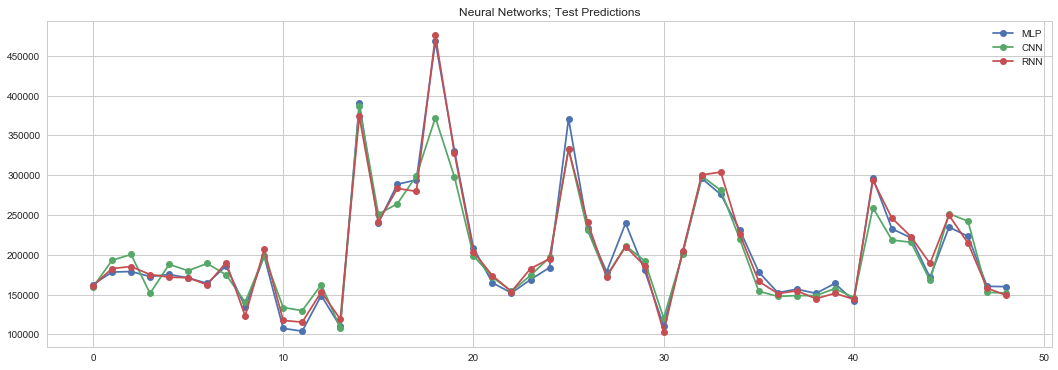

In [262]:
plt.figure(figsize = (18, 6))

plt.plot(target_mlp[1:50], '-o', label='MLP')
plt.plot(target_cnn[1:50], '-o', label='CNN')
plt.plot(target_rnn[1:50], '-o', label='RNN')

plt.legend()
plt.title('Neural Networks; Test Predictions');

## 11. Summary

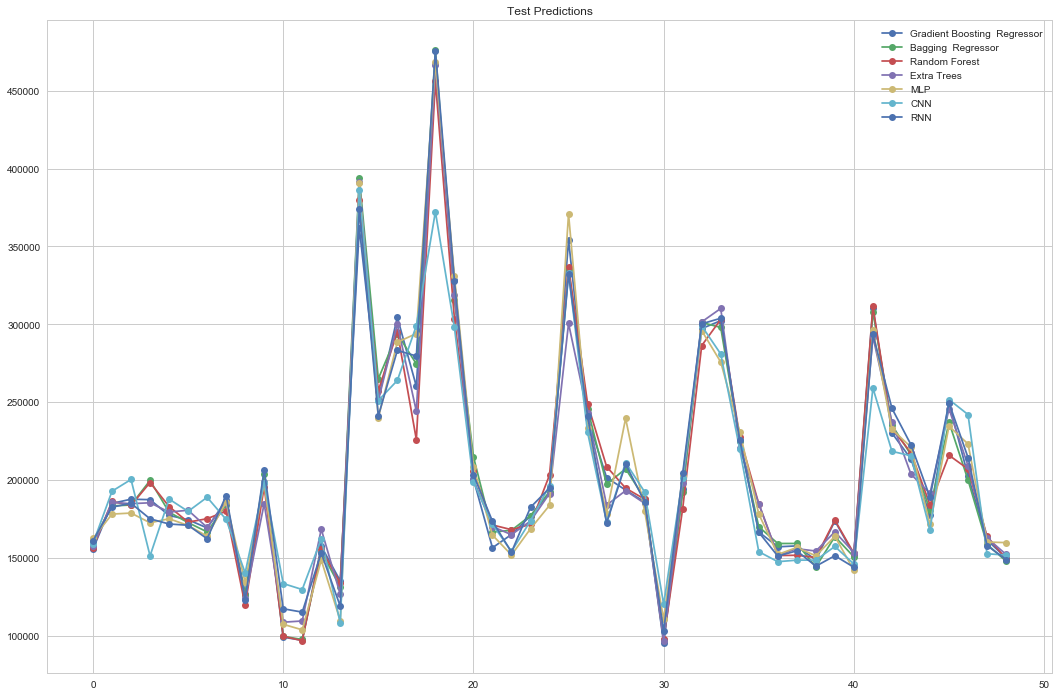

In [254]:
plt.figure(figsize = (18, 12))

plt.plot(target_predict[1:50], '-o', label='Gradient Boosting  Regressor')
plt.plot(target_predict1[1:50], '-o', label='Bagging  Regressor')
plt.plot(target_predict2[1:50], '-o', label='Random Forest')
plt.plot(target_predict3[1:50], '-o', label='Extra Trees')
plt.plot(target_mlp[1:50], '-o', label='MLP')
plt.plot(target_cnn[1:50], '-o', label='CNN')
plt.plot(target_rnn[1:50], '-o', label='RNN')

plt.legend()
plt.title('Test Predictions');